In [101]:
import json
import pandas as pd
import os
import numpy as np

from analysis.ADR import ADR
from analysis.FP import createFPTree, mineFPTree
from analysis.algrithm import spectrum, diff
from analysis.utils import load_collector, load_dst_hosts

# load data

In [102]:
# df1 = load_dst_hosts()
df2 = load_collector()
df = df2

In [103]:
df.head()

,timestamp,path,path_str,latency,detail
0,228557729083671,"[s8, s5, s10]","s8,s5,s10",5349,"s8-eth4,s5-eth7,s10-eth1"
1,228557729183220,"[s3, s7]","s3,s7",706,"s3-eth5,s7-eth1"
2,228557729220238,"[s1, s10, s6]","s1,s10,s6",3854,"s1-eth7,s10-eth6,s6-eth1"
3,228557729227249,"[s9, s1]","s9,s1",525,"s9-eth2,s1-eth1"
4,228557729239231,"[s5, s3]","s5,s3",260,"s5-eth3,s3-eth1"


In [104]:
log_dir = './host_log'
log_names = [os.path.splitext(l)[0] for l in os.listdir(log_dir) if l.endswith('.log') and "interface" not in l]
log_names.remove('h0-eth0')
print(log_names)

['h9-eth0', 'h6-eth0', 'h10-eth0', 'h8-eth0', 'h4-eth0', 'h5-eth0', 'h3-eth0', 'h1-eth0', 'h7-eth0', 'h2-eth0']


In [105]:
# load data
log_data = {}
for ln in log_names:
    with open(os.path.join(log_dir, ln+'.log'), 'r') as f:
        content = f.read()
        log_data[ln] = json.loads('['+content.rstrip(',\n')+']')
    

In [106]:
trace_data = []
for ln in log_names:
    for trace in log_data[ln]:
        trace_latency = trace[-1]['ingress_tstamp'] + trace[-1]['hop_latency'] - trace[0]['ingress_tstamp']
        if trace_latency < 0:
            print(trace)
        trace_data.append({
            'dst': ln,
            'timestamp': trace[0]['ingress_tstamp'],
            'path': frozenset(["s"+str(hop['switch_id']) for hop in trace]),
            # 'path': ','.join(["s"+str(hop['switch_id']) for hop in trace]),
            'latency': trace_latency,
            'detail': ','.join(["s{}-eth{}".format(hop['switch_id'], hop['egress_port']) for hop in trace]),
        })

In [107]:
# trace_data = []
# for ln in log_names:
#     for trace in log_data[ln]:
#         for i in range(len(trace)-1):
#             src, dst = trace[i:i+2]
#             hop_time = dst['ingress_tstamp'] - src['ingress_tstamp'] + dst['hop_latency']
#             trace_data.append({
#                 'latency': hop_time,
#                 'path': frozenset(["s"+str(hop['switch_id']) for hop in trace[i:i+2]]),
#             'timestamp': trace[0]['ingress_tstamp'],
#             })

In [108]:
df = pd.DataFrame(trace_data).sort_values(['timestamp'], ignore_index=True)
print(len(df))
df.head()

1288


,dst,timestamp,path,latency,detail
0,h10-eth0,228557729083671,"(s8, s10, s5)",5349,"s8-eth4,s5-eth7,s10-eth1"
1,h7-eth0,228557729183220,"(s3, s7)",706,"s3-eth5,s7-eth1"
2,h6-eth0,228557729220238,"(s6, s10, s1)",3854,"s1-eth7,s10-eth6,s6-eth1"
3,h1-eth0,228557729227249,"(s9, s1)",525,"s9-eth2,s1-eth1"
4,h3-eth0,228557729239231,"(s3, s5)",260,"s5-eth3,s3-eth1"


In [109]:
def FIM(fn='test'):
    content = ""
    for data in trace_data:
        content += ' '.join(data['path']).replace("s", "") + "\n"
    with open(f'middle/{fn}.txt', 'w') as f:
        f.write(content)
def FSP(df, fn="SequentialPattern"):
    content = ""
    for path in df['path']:
        content += ' -1 '.join(path).replace("s", "") + " -1 -2\n"
    with open(f'middle/{fn}.txt', 'w') as f:
        f.write(content)
# FSP(df)

In [119]:
df = load_collector()
df['path'] = [frozenset(p) for p in df['path'].tolist()]

# Analysis
## Abnormal Detection

In [120]:
# adr = ADR(volumn=100)
adr = ADR(volumn=len(df)/10)
for i, row in df.iterrows():
    lier = adr.feed(row['latency'])
    df.loc[i, 'lier'] = lier

error bar: 3 sigma


In [121]:
df[df['lier']=='out'].head()

,timestamp,path,path_str,latency,detail,lier
153,228557744845058,"(s6, s10, s1)","s1,s10,s6",6839,"s1-eth7,s10-eth6,s6-eth1",out
174,228557746935190,"(s3, s7)","s3,s7",9274,"s3-eth5,s7-eth1",out
271,228557757313281,"(s6, s10, s1)","s1,s10,s6",5238,"s1-eth7,s10-eth6,s6-eth1",out
295,228557759533138,"(s3, s6)","s6,s3",304096,"s6-eth2,s3-eth1",out
305,228557760584968,"(s3, s6)","s6,s3",297861,"s6-eth2,s3-eth1",out


In [122]:
hop_count = []
out_df = df[df['lier']=='out']
for hops in set(out_df['path'].to_list()):
    hop_count.append({
        'hop': hops,
        'count': len(out_df[df['path']==hops])
    })
hop_df = pd.DataFrame(hop_count).sort_values(['count'], ascending=False)
hop_df

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,hop,count
1,"(s2, s10)",29
0,"(s3, s6)",19
2,"(s6, s10, s1)",2
3,"(s3, s7)",1


In [123]:
# df[(df['path']>={'s16'}) & (df['lier']=='out')]

## 谱分析

In [ ]:
with open("topology.db", "r") as f:
    topo = json.load(f)
switchs = [node for node in topo.keys() if node.startswith('s')]
print(switchs)

['s9', 's8', 's3', 's2', 's1', 's0', 's7', 's6', 's5', 's4', 's10']


In [ ]:
# spectrum(df, switchs, 'dstar2', topN=10);
spectrum(df, switchs, 'ochiai', topN=10);


 ochiai Spectrum Result:
s2                                                : 0.25272871
s0                                                : nan
s10                                               : 0.21521455
s6                                                : 0.20915479
s3                                                : 0.14220924
s1                                                : 0.06087187
s9                                                : 0.01739196
s8                                                : 0.01229797
s7                                                : 0.00869598
s5                                                : 0.00709006
s4                                                : 0.00000000


/home/user/LDFI-mininet/pktrace-mininet/analysis/algrithm.py:65: RuntimeWarning: invalid value encountered in double_scalars
  result[switch] = cef / np.sqrt((cep + cef) * (cef + cnf))


## Frequent Item-set Mining (FIM)

In [129]:
C = {}
for _, line in (df[df['lier']=='out'].iterrows()):
    point = line.path
    C[point] = 1 + C.get(point, 0)

fptree, headPointTable = createFPTree(C)
frequentPatterns = {}
prefix = set([])
mineFPTree(headPointTable, prefix, frequentPatterns)

In [130]:
R_df = df[df['lier']=='out']
S_df = df[df['lier']=='in']
print(len(R_df), len(S_df))
ans_df = diff(frequentPatterns, R_df, S_df, th_supp=0.0, th_rr=0.0, fre_type='item')
ans_df[:10]

51 1110


,pattern,support,score
0,"(s2, s10)",0.568627,11.989723
1,"(s3, s6)",0.372549,5.400543
2,(s2),0.568627,5.278409
3,(s6),0.411765,2.803017
4,(s10),0.607843,2.328341
5,(s3),0.392157,1.513433
6,"(s6, s1)",0.039216,0.367699
7,"(s6, s10, s1)",0.039216,0.367699
8,"(s10, s1)",0.039216,0.367699
9,"(s6, s10)",0.039216,0.367699


In [131]:
frequentPatterns
# print(len(R_df[frozenset(['s2']) <= R_df['path']]))
# print(len(S_df[frozenset(['s2']) <= S_df['path']]))

{frozenset({'s7'}): 1,
 frozenset({'s3', 's7'}): 1,
 frozenset({'s1'}): 2,
 frozenset({'s1', 's6'}): 2,
 frozenset({'s1', 's10', 's6'}): 2,
 frozenset({'s1', 's10'}): 2,
 frozenset({'s3'}): 20,
 frozenset({'s3', 's6'}): 19,
 frozenset({'s6'}): 21,
 frozenset({'s10', 's6'}): 2,
 frozenset({'s2'}): 29,
 frozenset({'s10', 's2'}): 29,
 frozenset({'s10'}): 31}

# 流量图

In [ ]:
df.head()

,dst,timestamp,path,latency,detail,lier
0,h10-eth0,228557729083671,"(s8, s10, s5)",5349,"s8-eth4,s5-eth7,s10-eth1",unknow
1,h7-eth0,228557729183220,"(s3, s7)",706,"s3-eth5,s7-eth1",unknow
2,h6-eth0,228557729220238,"(s6, s10, s1)",3854,"s1-eth7,s10-eth6,s6-eth1",unknow
3,h1-eth0,228557729227249,"(s9, s1)",525,"s9-eth2,s1-eth1",unknow
4,h3-eth0,228557729239231,"(s3, s5)",260,"s5-eth3,s3-eth1",unknow


In [ ]:
from matplotlib import pyplot as plt

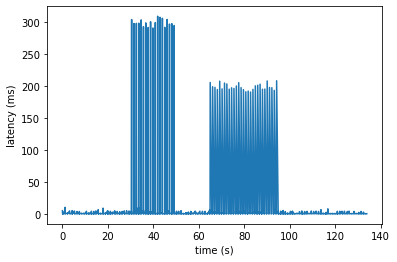

In [ ]:
x = np.array(df['timestamp'])/1e6
x = x - x[0]
plt.plot(x, df['latency']/1e3)
plt.xlabel("time (s)")
plt.ylabel("latency (ms)");
# plt.xticks([])

In [ ]:
(df['latency']/1e3)[:700]

0        5.349
1        0.706
2        3.854
3        0.525
4        0.260
        ...   
695      0.485
696      0.501
697      0.558
698    203.402
699      1.188
Name: latency, Length: 700, dtype: float64

---
# 其他分析

In [ ]:
trace_data = []
for ln in log_names:
    for trace in log_data[ln]:
        trace_latency = trace[-1]['ingress_tstamp'] + trace[-1]['hop_latency'] - trace[0]['ingress_tstamp']
        if trace_latency < 0:
            print(trace)
        trace_data.append({
            'timestamp': trace[0]['ingress_tstamp'],
            'path': frozenset(["s"+str(hop['switch_id']) for hop in trace]),
            'len': len(trace),
            'latency': trace_latency,
        })
trace_df = pd.DataFrame(trace_data).sort_values(['timestamp'], ignore_index=True)

In [ ]:
trace_df.head()

,timestamp,path,len,latency
0,228557729083671,"(s8, s10, s5)",3,5349
1,228557729183220,"(s3, s7)",2,706
2,228557729220238,"(s6, s10, s1)",3,3854
3,228557729227249,"(s9, s1)",2,525
4,228557729239231,"(s3, s5)",2,260


12.039632038834952 2622.46963017043


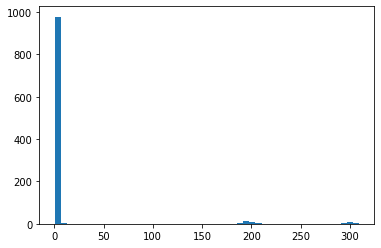

1.788996124031008 3.029489996109008


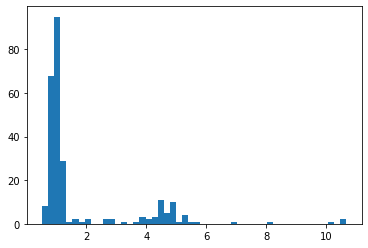

In [ ]:
for L in set(trace_df['len']):
    latency = np.array(trace_df[trace_df['len']==L]['latency'].to_list())/1e3
    print(np.mean(latency), np.var(latency))
    plt.hist(latency, bins=50)
    plt.show()
    # break